In [34]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [35]:
X, y = mnist["data"], mnist["target"]
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (70000, 784)
y.shape: (70000,)


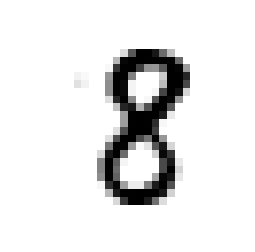

6.0


In [94]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from random import randint

rand_index = randint(0, 70000)
some_digit = X[rand_index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()
print(y[rand_num])

In [37]:
split_ind = 60000
X_train, y_train, X_test, y_test = X[:split_ind], y[:split_ind], X[split_ind:], y[split_ind:]

In [38]:
import numpy as np

shuffle_index = np.random.permutation(split_ind)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [39]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [40]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [41]:
from sklearn.metrics import mean_squared_error


pred_train_5 = sgd_clf.predict(X_train)
sgd_train_5_mse = mean_squared_error(y_train_5, pred_train_5)
sgd_train_5_rmse = np.sqrt(sgd_train_5_mse)
print(sgd_train_5_rmse)

0.188237438713


/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:239: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9573
0.96115
0.96525


In [43]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [44]:
never_5_clf = Never5Classifier()

In [45]:
from sklearn.model_selection import cross_val_score

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9093 ,  0.9108 ,  0.90885])

In [46]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9573 ,  0.96115,  0.96525])

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53780,   799],
       [ 1527,  3894]])

In [49]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, cross_val_predict(never_5_clf, X_train, y_train_5, cv=3))

array([[54579,     0],
       [ 5421,     0]])

In [50]:
from sklearn.metrics import precision_score, recall_score

print("precision:", precision_score(y_train_5, y_train_pred))
print("recall:", recall_score(y_train_5, y_train_pred))

precision: 0.829746430854
recall: 0.718317653569


In [51]:
from sklearn.metrics import f1_score

print("f1_score:", f1_score(y_train_5, y_train_pred))

f1_score: 0.770021752027


In [52]:
class MySGDClassifier(BaseEstimator):
    def __init__(self, thresh=0):
        self.thresh = thresh
        self.sgd_clf = SGDClassifier(random_state=42)
    def fit(self, X, y=None):
        self.sgd_clf.fit(X, y)
    def predict(self, X, y=None):
        cust_result = (self.sgd_clf.decision_function(X) > self.thresh)
        return cust_result

In [53]:
my_sgd_clf = MySGDClassifier(thresh=70000)
my_5_pred = cross_val_predict(my_sgd_clf, X_train, y_train_5, cv=3)
print("cross_val_score:", cross_val_score(my_sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))
print("confusion_matrix:\n", confusion_matrix(y_train_5, my_5_pred))
print("precision:", precision_score(y_train_5, my_5_pred))
print("recall:", recall_score(y_train_5, my_5_pred))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda/lib/python3.6/site-packages/sklear

cross_val_score: [ 0.9607   0.9469   0.94495]
confusion_matrix:
 [[54341   238]
 [ 2711  2710]]
precision: 0.919267299864
recall: 0.499907766095


In [54]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [55]:
from sklearn.metrics import precision_recall_curve

print("y_scores:\n", y_scores)
print("y_scores.shape:\n", y_scores.shape)
print("y_train_5.shape:\n", y_train_5.shape)

cor_y_scores = [item[1] for item in y_scores]
precisions, recalls, thresholds = precision_recall_curve(y_train_5, cor_y_scores)

y_scores:
 [[      0.         -480557.10788233]
 [      0.         -653104.93150334]
 [      0.         -511377.65922836]
 ..., 
 [      0.          167142.3770602 ]
 [      0.         -390041.53927768]
 [      0.         -503429.06856887]]
y_scores.shape:
 (60000, 2)
y_train_5.shape:
 (60000,)


In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

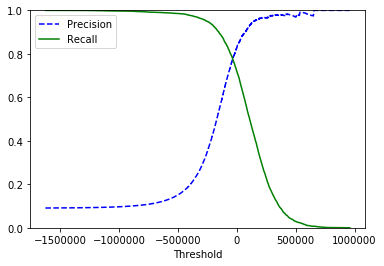

In [57]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, cor_y_scores)

In [59]:
def plot_roc_curve(fpr, tpr, label=None, style=None):
    if style:
        plt.plot(fpr, tpr, style, linewidth=2, label=label)
    else:
        plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

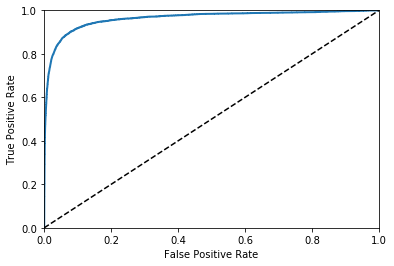

In [60]:
plot_roc_curve(fpr, tpr, "SGD")
plt.show()

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, cor_y_scores)

0.96306228381099468

In [62]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

print("shape is:", y_probas_forest.shape)
print("content is:", y_probas_forest)

shape is: (60000, 2)
content is: [[ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 ..., 
 [ 0.   1. ]
 [ 1.   0. ]
 [ 0.9  0.1]]


In [63]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

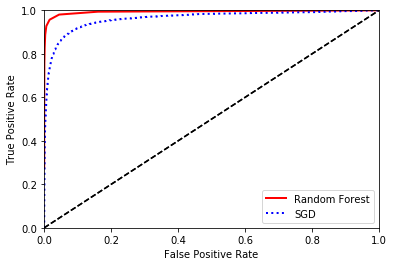

In [64]:
# plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest", "r-")
plot_roc_curve(fpr, tpr, "SGD", "b:")
plt.legend(loc="lower right")
plt.show()

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.99359495106475815

In [66]:
forest_clf_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("cross_val_score:", cross_val_score(forest_clf, X_train, y_train_5, cv=3, scoring="accuracy"))
print("confusion_matrix:\n", confusion_matrix(y_train_5, my_5_pred))
print("precision:", precision_score(y_train_5, forest_clf_pred))
print("recall:", recall_score(y_train_5, forest_clf_pred))

cross_val_score: [ 0.98365  0.98335  0.98225]
confusion_matrix:
 [[54341   238]
 [ 2711  2710]]
precision: 0.983114035088
recall: 0.826969193876


In [67]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [68]:
sgd_clf.predict([some_digit])

array([ 6.])

In [69]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])


[[-818697.19486223 -633861.45007646 -425419.18688511 -550795.90446749
  -359632.74590439 -252560.94620229  295282.23118891 -769364.69559235
  -486975.22474858 -462193.21237499]]
6
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
5.0


In [70]:
from sklearn.multiclass import OneVsOneClassifier


ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

In [71]:
ovo_clf.predict([some_digit])

array([ 6.])

In [72]:
print(ovo_clf.decision_function([some_digit]))

[[ 2.79519523  0.74295999  7.05502565  3.97714275  8.22760598  5.0077551
   9.5        -0.19582025  6.00094864  1.88918691]]


In [73]:
print(ovo_clf.classes_)
len(ovo_clf.estimators_)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


45

In [74]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 6.])

In [75]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87392521,  0.88044402,  0.82647397])

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91371726,  0.90859543,  0.91153673])

In [78]:
print(X_train_scaled[1])

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.41807799e-03  -5.75481961e-03  -4.08251693e-03  -4.08251693e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.08251693e-03  -4.70968827e-03  -8.79934640e-03  -1.15905591e-02
  -1.47589798e-02  -1.92848546e-02  -2.46717975e-02  -2.90710271e-02
  -3.05926583e-02  -3.11640127e-02  -3.19628719e-02  -3.02025355e-02
  -3.13102175e-02  -2.83833960e-02  -2.31191906e-02  -1.91666260e-02
  -1.67723008e-02  -1.09963601e-02  -8.32486080e-03  -4.38069356e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [79]:
print(X_train[1])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  51 128 212 254 254 255 169 114   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  26 164 247 254 253 232 206
 254 253 251  63   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  83 224 253 244 146  46  25   0 186 253 25

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5743,    2,   22,   10,   10,   44,   42,    9,   38,    3],
       [   1, 6489,   44,   22,    6,   40,    5,   14,  110,   11],
       [  58,   36, 5344,   96,   76,   23,   90,   62,  159,   14],
       [  53,   41,  137, 5361,    2,  217,   35,   60,  131,   94],
       [  22,   25,   33,   10, 5388,    9,   54,   30,   87,  184],
       [  71,   46,   36,  184,   66, 4618,  101,   28,  177,   94],
       [  35,   28,   48,    2,   37,   92, 5626,    4,   45,    1],
       [  24,   18,   66,   27,   54,    8,    6, 5870,   14,  178],
       [  51,  159,   67,  164,   15,  151,   58,   31, 5023,  132],
       [  45,   33,   26,   91,  177,   30,    3,  253,   76, 5215]])

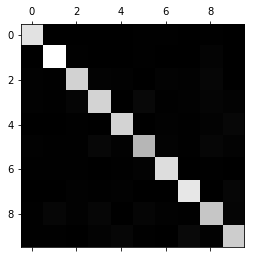

In [81]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [82]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums
print(norm_conf_mx)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[  9.69609995e-01   3.37666723e-04   3.71433395e-03   1.68833361e-03
    1.68833361e-03   7.42866790e-03   7.09100118e-03   1.51950025e-03
    6.41566774e-03   5.06500084e-04]
 [  1.48323939e-04   9.62474043e-01   6.52625334e-03   3.26312667e-03
    8.89943637e-04   5.93295758e-03   7.41619697e-04   2.07653515e-03
    1.63156333e-02   1.63156333e-03]
 [  9.73481034e-03   6.04229607e-03   8.96945284e-01   1.61127895e-02
    1.27559584e-02   3.86035582e-03   1.51057402e-02   1.04061766e-02
    2.66868077e-02   2.34978181e-03]
 [  8.64459305e-03   6.68732670e-03   2.23454575e-02   8.74408742e-01
    3.26211059e-04   3.53938999e-02   5.70869352e-03   9.78633176e-03
    2.13668243e-02   1.53319198e-02]
 [  3.76583362e-03   4.27935638e-03   5.64875043e-03   1.71174255e-03
    9.22286888e-01   1.54056830e-03   9.24340979e-03   5.13522766e-03
    1.48921602e-02   3.14960630e-02]
 [  1.30972145e-02   8.48551928e-0

[[ 0.          0.00033767  0.00371433  0.00168833  0.00168833  0.00742867
   0.007091    0.0015195   0.00641567  0.0005065 ]
 [ 0.00014832  0.          0.00652625  0.00326313  0.00088994  0.00593296
   0.00074162  0.00207654  0.01631563  0.00163156]
 [ 0.00973481  0.0060423   0.          0.01611279  0.01275596  0.00386036
   0.01510574  0.01040618  0.02668681  0.00234978]
 [ 0.00864459  0.00668733  0.02234546  0.          0.00032621  0.0353939
   0.00570869  0.00978633  0.02136682  0.01533192]
 [ 0.00376583  0.00427936  0.00564875  0.00171174  0.          0.00154057
   0.00924341  0.00513523  0.01489216  0.03149606]
 [ 0.01309721  0.00848552  0.00664084  0.03394208  0.01217488  0.
   0.01863125  0.0051651   0.0326508   0.01733997]
 [ 0.00591416  0.00473133  0.00811085  0.00033795  0.00625211  0.01554579
   0.          0.0006759   0.00760392  0.00016898]
 [ 0.00383081  0.0028731   0.01053472  0.00430966  0.00861931  0.00127694
   0.0009577   0.          0.00223464  0.02841181]
 [ 0.0087

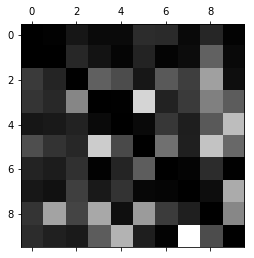

In [83]:
np.fill_diagonal(norm_conf_mx, 0)
print(norm_conf_mx)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [84]:
my_ary = np.array([i for i in range(10)]).reshape(2,5)
print(my_ary)

[[0 1 2 3 4]
 [5 6 7 8 9]]


In [85]:
print('my_ary.sum() =', my_ary.sum())
print('my_ary.sum(axis=0) =', my_ary.sum(axis=0))
print('my_ary.sum(axis=0, keepdims=True) =', my_ary.sum(axis=0, keepdims=True))
print('my_ary.sum(axis=1) =', my_ary.sum(axis=1))
print('my_ary.sum(axis=1, keepdims=True) =', my_ary.sum(axis=1, keepdims=True))

my_ary.sum() = 45
my_ary.sum(axis=0) = [ 5  7  9 11 13]
my_ary.sum(axis=0, keepdims=True) = [[ 5  7  9 11 13]]
my_ary.sum(axis=1) = [10 35]
my_ary.sum(axis=1, keepdims=True) = [[10]
 [35]]


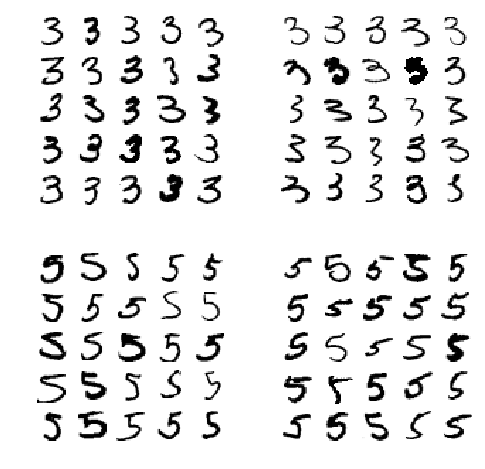

In [86]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

In [87]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
print(y_multilabel)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

[[False  True]
 [ True  True]
 [False  True]
 ..., 
 [False  True]
 [ True False]
 [False False]]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [88]:
knn_clf.predict([some_digit])

array([[False, False]], dtype=bool)

In [103]:
knn_clf.decision_function([some_digit])

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [89]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [92]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

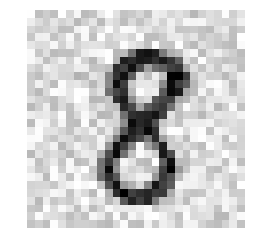

In [98]:
plot_digit(X_test_mod[some_index])

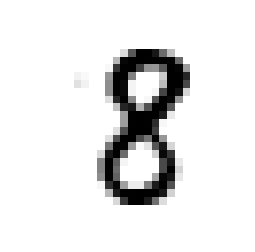

In [99]:
plot_digit(X_test[some_index])

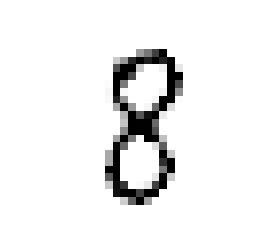

In [100]:
some_index = rand_index - 60000
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [104]:
my_knn_clf = KNeighborsClassifier()

In [117]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_dict = {"n_neighbors": [i for i in range(2, 11)], "weights": ["uniform", "distance"], 
              "leaf_size":[5 * i for i in range(4, 8)], "p": [i for i in range(1, 3)]}


rand_search_knn = RandomizedSearchCV(my_knn_clf, param_dict, n_iter=10, scoring="accuracy", n_jobs=-1, verbose=2)

In [ ]:
rand_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] weights=distance, p=2, n_neighbors=5, leaf_size=35 ..............
[CV] weights=distance, p=2, n_neighbors=5, leaf_size=35 ..............
[CV] weights=distance, p=2, n_neighbors=5, leaf_size=35 ..............
[CV] weights=uniform, p=2, n_neighbors=7, leaf_size=30 ...............
[CV]  weights=distance, p=2, n_neighbors=5, leaf_size=35, total=33.4min
[CV] weights=uniform, p=2, n_neighbors=7, leaf_size=30 ...............
[CV]  weights=distance, p=2, n_neighbors=5, leaf_size=35, total=33.4min
[CV] weights=uniform, p=2, n_neighbors=7, leaf_size=30 ...............
[CV]  weights=uniform, p=2, n_neighbors=7, leaf_size=30, total=33.5min
[CV] weights=distance, p=1, n_neighbors=8, leaf_size=25 ..............
[CV]  weights=distance, p=2, n_neighbors=5, leaf_size=35, total=33.5min
[CV] weights=distance, p=1, n_neighbors=8, leaf_size=25 ..............
[CV]  weights=distance, p=1, n_neighbors=8, leaf_size=25, total=27.3min
[CV] weights

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 712.6min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'leaf_size': [20, 25, 30, 35], 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=2)

In [129]:
rand_search_knn.cv_results_

{'mean_fit_time': array([  44.04965965,   44.82232865,   70.4579583 ,  132.20993463,
         117.80625701,  107.39496907,  121.93649165,  103.88088401,
         134.15343062,   92.82726924]),
 'mean_score_time': array([ 1962.34195844,  1857.40840602,  1743.43612989,  2281.4211483 ,
         1975.38375727,  1670.65985219,  1680.61895776,  1796.15275399,
         1977.5051717 ,  1308.91934307]),
 'mean_test_score': array([ 0.96946667,  0.967     ,  0.96203333,  0.96971667,  0.96826667,
         0.96143333,  0.96005   ,  0.97025   ,  0.96553333,  0.96826667]),
 'mean_train_score': array([ 1.        ,  0.97563331,  1.        ,  1.        ,  1.        ,
         0.97427496,  0.97025827,  1.        ,  0.97289164,  1.        ]),
 'param_leaf_size': masked_array(data = [35 30 25 20 35 30 20 25 35 25],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_n_neighbors': masked_array(data = [5 7 8 2 7 5 7 3 9 7],
              mask =

In [130]:
rand_search_knn.best_params_

{'leaf_size': 25, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

In [132]:
rand_search_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='distance')

In [193]:
import numpy as np

from scipy.ndimage.interpolation import shift

def shift_by_one_pixel_in_all_dir(X_set, y_set):
    new_X_set = []
    new_y_set = []
    for i in range(4):
        new_y_set += np.ndarray.tolist(y_set)
        for row in X_set:
            if i == 0:
                new_x = shift(row.reshape(28, 28), [1, 0], cval=0).reshape(-1)
            elif i == 1:
                new_x = shift(row.reshape(28, 28), [-1, 0], cval=0).reshape(-1)
            elif i == 2:
                new_x = shift(row.reshape(28, 28), [0, 1], cval=0).reshape(-1)
            else:
                new_x = shift(row.reshape(28, 28), [0, -1], cval=0).reshape(-1)
            new_X_set.append(new_x)
    new_X_set = np.array(new_X_set)
    new_y_set = np.array(new_y_set)
    return np.concatenate((X_set, new_X_set), axis=0), np.concatenate((y_set, new_y_set), axis=0), 

In [194]:
new_X_train, new_y_train = shift_by_one_pixel_in_all_dir(X_train, y_train)

In [203]:
best_knn_clf = rand_search_knn.best_estimator_

In [204]:
best_knn_clf.fit(new_X_train,  new_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='distance')

In [207]:
y_test_pred = best_knn_clf.predict(X_test)

In [211]:
final_mse = mean_squared_error(y_test, y_test_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

0.66430414720969488

In [208]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.97629999999999995